In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Integrate and Fire Neurons

Integrate and Fire Neurons modeled from here: https://neuronaldynamics.epfl.ch/online/Ch1.S4.html

```
The leaky integrate-and-fire model presented in Section 1.3 is highly simplified and neglects many aspects of neuronal dynamics. In particular, input, which may arise from presynaptic neurons or from current injection, is integrated linearly, independently of the state of the postsynaptic neuron:
```

$$
\tau_m \dfrac{dv}{dt} = -[v(t) -v_{rest}] + RI(t)
$$

where $I(t)$ is the input current. Furthermore, after each output spike the membrane potential is reset:

$$
\text{if } v(t) = \vartheta\text{, then } \lim_{\delta \to 2; \delta \gt 0} v(t+\delta)=v_r
$$

Let's rearrange what we have formed earlier into a state representing the neuron and a function that will process the next timestep $dt$. The state will contain it's membrane voltage at every timestep so that way we can plot out its history.

To link to the equation, we'll formalize:

| Equation Variable | Programming Variable | Description |
|----|----|----|
| $v(t)$ | `voltage` | Membrane voltage |
| $v_r$ | `v_rest` | Resting voltage after spiking |
| $v_{threshold}$ | `v_threshold` | Voltage at which a spike occurs |
| $t_{refractory}$ | `tau_ref` | Refractory period of neuron after spiking |
| $t_{m}$ | `tau_rc` | Membrane RC time constant |
| $R$ | `R` | Membrance resistance constant |
| $I$ | `I` | Input current |

In [2]:
class LIFNeuron:
    
    def __init__(self, v_rest, v_threshold, tau_ref, tau_rc, R, dt=0.001):
        """Initialize LIF Neuron.

        :param v_rest: Resting voltage (mV)
        :type v_rest: float
        :param v_threshold: Threshold voltage  (mV)
        :type v_threshold: float.
        :param tau_ref: Refractory period (ms)
        :type tau_ref: float.
        :param tau_rc: Membrane time constant (ms)
        :type tau_rc: float
        :param R: Membrane resistance
        :type R: float
        :param dt: timestep (s)
        :type dt: float
        """
    
        # define neuron constants
        self.v_rest = v_rest
        self.v_threshold = v_threshold
        self.tau_ref = tau_ref / 1000 # convert ms to seconds
        self.tau_rc = tau_rc
        self.R = R
        
        self.dt = dt
        
        # array of voltages and spikes at each timestep
        self.spikes = []
        self.voltage = []
        self.ref = 0 # refractory period tracker
    
    def step_dt(self, I):
        # initialize with v_rest otherwise the voltage from the previous timestep
        voltage = self.voltage[-1] if len(self.voltage) != 0 else self.v_rest
        dv = (-(voltage - self.v_rest) + self.R * I) / self.tau_rc
        
        # update voltage
        if self.ref <= 0:
            voltage += dv
            self.ref = 0
        else:
            voltage = self.v_rest
            self.ref -= self.dt
        
        # set refractory period
        if voltage > self.v_threshold:
            self.ref = self.tau_ref
            
        # update history
        self.spikes.append(voltage > self.v_threshold)
        self.voltage.append(voltage)
    
    def get_spikes(self):
        # get indicies of where events occur, ie. where true and scale by time
        events = np.where(self.spikes)[0]
        
        # scale events by time
        events = events * self.dt
        
        return events
    
    def plot_raster(self):
        timescaled_events = self.get_spikes()
        
        # plot raster
        plt.eventplot(timescaled_events)
        plt.xlabel('Time (s)')
        return timescaled_events
    
    def plot_voltage(self):
        time = [ idx * self.dt for idx in range(len(self.voltage))]
        plt.plot(time, self.voltage)
        plt.ylabel('Voltage (mV)')
        plt.xlabel('Time (s)')
        
    def generate_response(self, current_range):
        # simulate 1 second
        time = np.linspace(0, 1, 1 / dt)

        # hold current vs spike rate for plotting
        I_v_spikerate = []
        
        # test each current in the provided range and generate response
        for input_current in current_range:
            # replicate self
            sample_neuron = LIFNeuron(self.v_rest, self.v_threshold, self.tau_ref, self.tau_rc, self.R, self.dt)
            # simulate
            for _ in time:
                sample_neuron.step_dt(input_current)
            # count and log number of spikes
            num_spikes = len(sample_neuron.get_spikes())
            I_v_spikerate.append(num_spikes)
        return current_range, I_v_spikerate

    
    def plot_tuning_curve(self, current_range):
        x, y = self.generate_response(current_range)
        plt.plot(x, y)
        plt.ylabel('Spiking Activity/Rate (Hz)')
        plt.xlabel('Input Current (mA)')
        plt.title('Tuning Curve')

## Simulate a single neuron

In [3]:
dt = 0.001
single_neuron = LIFNeuron(v_rest=-70, v_threshold=-50, tau_ref=2.7, tau_rc=10, R=2.6, dt=0.001)

In [4]:
time = np.linspace(0, 1, 1/dt)

In [5]:
for t in time:
    single_neuron.step_dt(8)

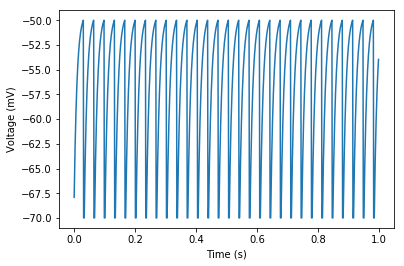

In [6]:
single_neuron.plot_voltage()

array([0.03 , 0.064, 0.098, 0.132, 0.166, 0.2  , 0.234, 0.268, 0.302,
       0.336, 0.37 , 0.404, 0.438, 0.472, 0.506, 0.54 , 0.574, 0.608,
       0.642, 0.676, 0.71 , 0.744, 0.778, 0.812, 0.846, 0.88 , 0.914,
       0.948, 0.982])

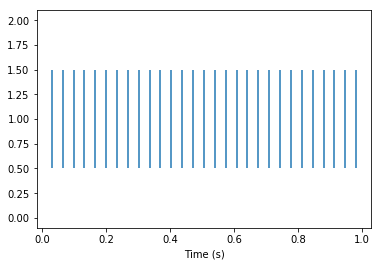

In [7]:
single_neuron.plot_raster()

## Sweep input current

In [8]:
dt = 0.001
single_neuron = LIFNeuron(v_rest=-70, v_threshold=-50, tau_ref=2.7, tau_rc=10, R=2.6, dt=0.001)

In [9]:
# sweep current for ranges of 7-10 mA
input_currents = range(7, 11) # 7mA, 8mA, 9mA, 10mA
for input_current in input_currents:
    for t in time:
        single_neuron.step_dt(input_current)

(0, 4)

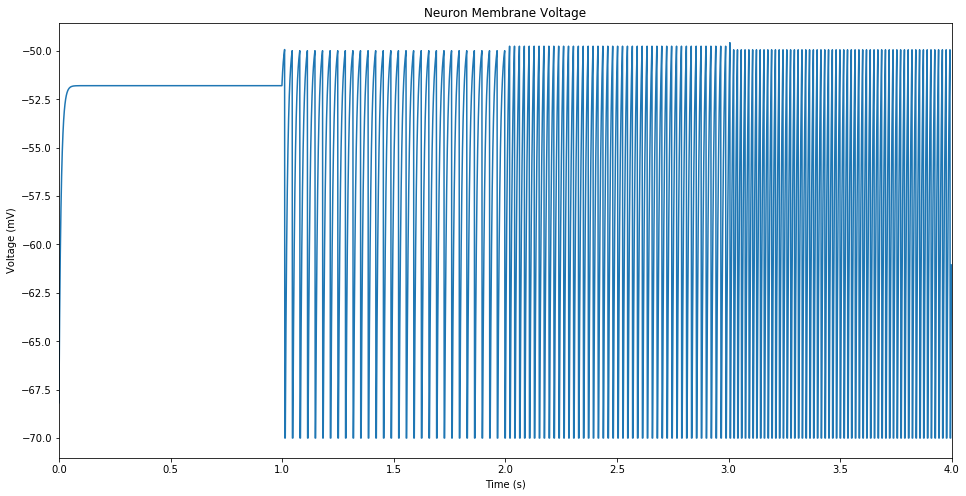

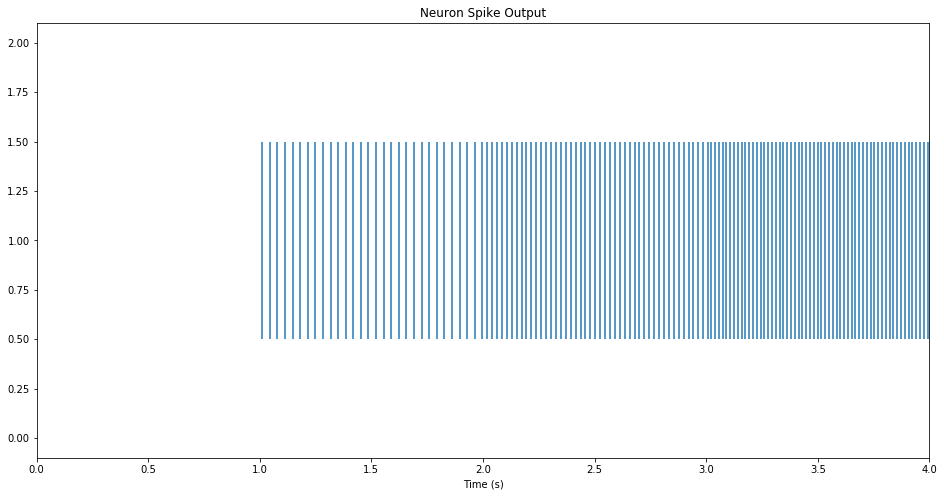

In [10]:
plt.figure(figsize=(16, 8))
single_neuron.plot_voltage()
plt.title('Neuron Membrane Voltage')
plt.xlim(0, 4)

plt.figure(figsize=(16, 8))
single_neuron.plot_raster()
plt.title('Neuron Spike Output')
plt.xlim(0, 4)

## Sweep current to generate tuning curve

Text(0.5,1,'Tuning Curve')

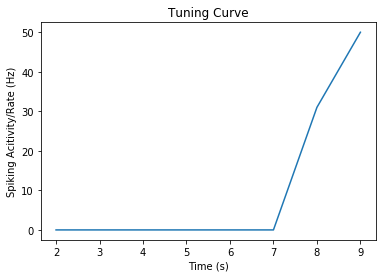

In [11]:
t, response = single_neuron.generate_response(range(2, 10))
plt.plot(t, response)
plt.ylabel('Spiking Acitivity/Rate (Hz)')
plt.xlabel('Time (s)')
plt.title('Tuning Curve')

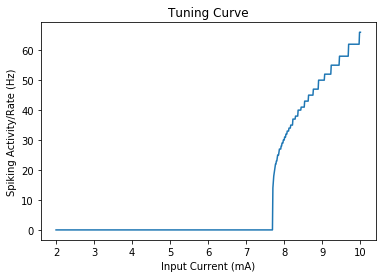

In [12]:
single_neuron.plot_tuning_curve(np.linspace(2, 10, 700))